In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import random
from torch.utils.data import Dataset,sampler,DataLoader
import torch
import torch.nn as nn

In [2]:
series = [30,21,29,31,40,48,53,47,37,39,31,29,17,9,20,24,27,35,41,38,
          27,31,27,26,21,13,21,18,33,35,40,36,22,24,21,20,17,14,17,19,
          26,29,40,31,20,24,18,26,17,9,17,21,28,32,46,33,23,28,22,27,
          18,8,17,21,31,34,44,38,31,30,26,32]

In [3]:
#for training we take hte first x elements
train=series[:50]

In [4]:
#for testing we take all elements (because we test on the las n, but get all for fitting. )
test=series

In [5]:
#Dataset with random shuffeling: We have to check, that seasonality gets shifted apropriatly 
class sequence_labeling_dataset(Dataset):
    
    def __init__(self, input,max_size=100,sequence_labeling=True,seasonality=12):     
        
        self.data=input
        self.max_size=max_size
        self.sequence_labeling=sequence_labeling
        self.seasonality=seasonality

    def __len__(self):
        
        return int(len(self.data))
    
    def __getitem__(self, index):
        
        data_i=self.data
        
        if len(data_i)>self.max_size:
            # i think the random shifts are the way to go, needs further testing though. 
            max_rand_int=len(data_i)-self.max_size
            #take a random start integer
            start_int=random.randint(0,max_rand_int)
            data_i=data_i[start_int:(start_int+self.max_size)]
        else:
            start_int=0
            
        #Lets try to forecast one whole seasonality 
        #should be all but the last as the input 
        
        inp=np.array(data_i[:-self.seasonality])
        
        #This is Sequence Classification
        if self.sequence_labeling==True:
            #this is sequence labeling
            out=np.array(data_i[1:])
        else:
            out=np.array(data_i[-self.seasonality:])
            

        #k=int((init_shift-1)/self.seasonality)
        #shift_steps=self.seasonality+init_shift-self.seasonality*(k+1)
        shift_steps=start_int%self.seasonality
        
        return inp, out,shift_steps
    

In [ ]:
#Should the model only fit the future or also fit the past? Maybe it should fit the past
#with a decreased parameter? Having to fit the past could be a good regularization. 



In [8]:
#Parameter: 
#1. The data series, 2. the max size we set for the series, 3rd if we want to return the whole (shifted) Sequence as output


sl=sequence_labeling_dataset(train,48,False)
sl_t=sequence_labeling_dataset(test,1000,False)




train_dl= DataLoader(dataset=sl,
                      batch_size=1024,
                      shuffle=False)

test_dl= DataLoader(dataset=sl_t,
                      batch_size=512,
                      shuffle=False)


In [9]:
#THe single series, holt winters model 
#this can also be used for a hierachical model (by instantiating multiple of those)
#we can also combine this with LST, and use the outputed, Trend and Seasonality for normalizing. 
#This is decently debugged :

#1. THe season shifts work, the parameters get trained. 
# NExt I can compare it to a standard HW implementation. 
#Ths is the additive version.

class holt_winters(torch.nn.Module):
    
    def __init__(self,init_a=0.1,init_b=0.1,init_g=0.1,init_t=0.1,slen=12):
      
        super(holt_winters, self).__init__()
        
        #Smoothing parameters
        self.alpha=torch.nn.Parameter(torch.tensor(init_a))
        self.beta=torch.nn.Parameter(torch.tensor(init_b))
        self.gamma=torch.nn.Parameter(torch.tensor(init_g))
        
        #init parameters
        self.init_season=torch.nn.Parameter(torch.tensor(np.random.random(size=slen)))
        self.init_trend=torch.nn.Parameter(torch.tensor(init_t))
        
        #season legnth used to pick appropriate past season step 
        self.slen=slen
        
        #Sigmoid used to norm the params to be betweeen 0 and 1 if needed 
        self.sig=nn.Sigmoid()
        
    def forward(self,series ,n_preds,series_shifts,rv=False):
        
        #Get Batch size
        batch_size=series.shape[0]
        
        #Get the initial seasonality parameter
        init_season_batch=self.init_season.repeat(batch_size).view(batch_size,-1)
        
        #We use roll to Allow for our random input shifts.
        seasonals=torch.stack([torch.roll(j,int(rol)) for j,rol in zip(init_season_batch,series_shifts)]).float()
        
        #It has to be a list such that we dont need inplace tensor changes. 
        seasonals=list(torch.split(seasonals,1,dim=1))
        seasonals=[x.squeeze() for x in seasonals]
        
        #Now We loop over the input in each forward step
        result = []
        
        #rv can be used for decomposing a series. 
        if rv==True:
            value_list=[]
            trend_list=[]
            season_list=[]
        

        for i in range(series.shape[1]+n_preds):
            
            #0th step we init the parameter 
            if i == 0: 

                smooth = series[:,0]
                trend = self.init_trend.repeat(batch_size)

                
                result.append(series[:,0])

                continue

            #smoothing
            if i <series.shape[1]:

                val = series[:,i]

                last_smooth, smooth = smooth, self.sig(self.alpha)*(val-seasonals[i%self.slen]) + (1-self.sig(self.alpha))*(smooth+trend)

                trend = self.sig(self.beta) * (smooth-last_smooth) + (1-self.sig(self.beta))*trend
                seasonals[i%self.slen] = self.sig(self.gamma)*(val-smooth) + (1-self.sig(self.gamma))*seasonals[i%self.slen]
                
                if rv==True:
                    value_list.append(smooth)
                    trend_list.append(trend)
                    season_list.append(seasonals[i%self.slen])

                    result.append(smooth+trend+seasonals[i%self.slen])
            
            #Forecasting (here we see why its called linear trend methods) also used for fitting
            else:
                m = i - len(series) + 1
                #An itneresting thing is we never really tell the model : THis is a value, this is a trend and this is a season
                #Instead we do the following: Here is something that is constant (value) here is something that is linearly changing
                #(trend) and here is something that is repeating (seasonals) and then we smooth all of those values. 
    
                result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                if rv==True:
                    value_list.append(smooth)
                    trend_list.append(trend)
                    season_list.append(seasonals[i%self.slen])
                
        if rv==False:
            return torch.stack(result,dim=1)
        else:
            return torch.stack(result,dim=1),value_list,trend_list,season_list
                

In [10]:
hw=holt_winters().cuda()

In [14]:
opti = torch.optim.Adam(hw.parameters(), lr=0.1)#,weight_decay=0.0001

In [15]:
loss_list=[]


In [16]:
for j in range(500):
    for batch in iter(train_dl):

        opti.zero_grad()
        inp=batch[0].float().cuda()#.unsqueeze(2)
        out=batch[1].float().cuda()#.unsqueeze(2).float()
        shifts=batch[2].numpy()
        #it returns the whole sequence atm 
        pred=hw(inp,12,shifts)[:,-12:]
        loss=torch.mean(torch.abs(pred-out))
        loss.backward()
        opti.step()
        if loss < 0.5:
            break
            
    for batch in iter(test_dl):
        opti.zero_grad()
        inp=batch[0].float().cuda()#.unsqueeze(2)
        out=batch[1].float().cuda()#.unsqueeze(2).float()
        shifts=batch[2].numpy()
        pred=hw(inp,12,shifts)[:,-12:]
        loss=torch.mean(torch.abs(pred-out))
        loss_list.append(loss.detach().cpu().numpy())
        print(loss)
    

tensor(6.1509, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(5.9118, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(5.7459, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(5.5450, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(5.3051, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(5.0126, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(4.6655, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(4.2814, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(4.0414, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(3.7408, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(3.3989, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(3.0314, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.6711, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.4741, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.3790, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.4232, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.4670, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.4807, device='cuda:0',

tensor(3.0003, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.9992, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(3.0017, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.9968, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.9886, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.9747, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.9750, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.9911, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(3.0159, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(3.0309, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(3.0275, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(3.0130, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(3.0043, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(3.0087, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(3.0190, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(3.0209, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(3.0148, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(3.0136, device='cuda:0',

KeyboardInterrupt: 

In [17]:
hw=hw.cpu()

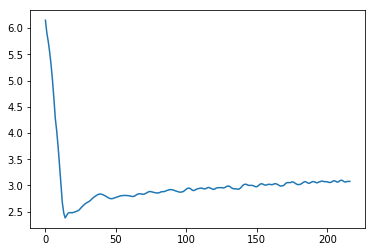

In [18]:
plt.plot(loss_list)

In [19]:
batch =  next(iter(test_dl))

In [142]:
inp=batch[0].float()#.unsqueeze(2)
out=batch[1].float()#.unsqueeze(2).float()
shifts=batch[2].numpy()
#it returns the whole sequence atm 
pred=hw(inp,1,shifts,True)#[:,-12:]
#loss=torch.mean(torch.abs(pred-out))

In [143]:
inp=inp.squeeze().numpy()

In [144]:
p=pred[0][0,:].detach().squeeze().numpy()

In [145]:
v=torch.stack([x[0] for x in pred[1]]).detach().numpy()

In [146]:
t=torch.stack([x[0] for x in pred[2]]).detach().numpy()

In [150]:
t

array([1.5728395 , 1.5723904 , 1.5543175 , 1.5985733 , 1.6414142 ,
       1.7296828 , 1.7220213 , 1.6962539 , 1.6456476 , 1.5588684 ,
       1.4122493 , 1.2887192 , 1.142996  , 1.0713861 , 1.0135688 ,
       0.97502947, 0.95310575, 0.9812869 , 0.97614247, 0.95724964,
       0.93518984, 0.90913075, 0.84173584, 0.81588835, 0.76102924,
       0.7257262 , 0.65819716, 0.67025006, 0.6545414 , 0.6672005 ,
       0.65687585, 0.6242133 , 0.58303726, 0.54964024, 0.49206513,
       0.47266796, 0.46115115, 0.4303142 , 0.40532154, 0.38477746,
       0.35826743, 0.3855846 , 0.3702924 , 0.35841516, 0.34927592,
       0.32517412, 0.3321281 , 0.3224163 , 0.29067138, 0.27690136,
       0.27541304, 0.27350286, 0.2702976 , 0.31496224, 0.3077356 ,
       0.30698165, 0.31166735, 0.30427417, 0.29883078, 0.29883078],
      dtype=float32)

In [147]:
s=torch.stack([x[0] for x in pred[3]]).detach().numpy()

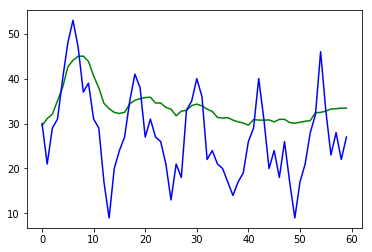

In [149]:
plt.plot(v,"g")
plt.plot(inp[0,:],"b")

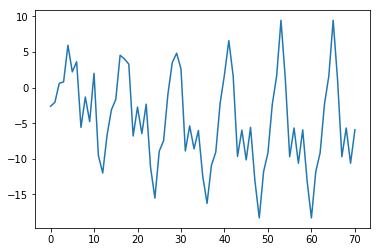

In [129]:
plt.plot(s)


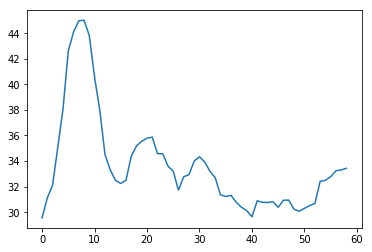

In [58]:
plt.plot(v)


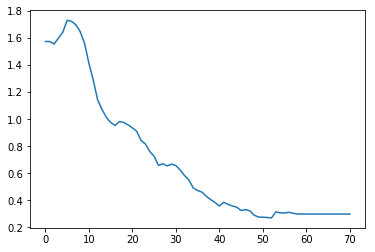

In [49]:
plt.plot(t)

In [29]:
pred=pred.detach().numpy()

In [30]:
out=out.detach().numpy()
inp=inp.detach().numpy()

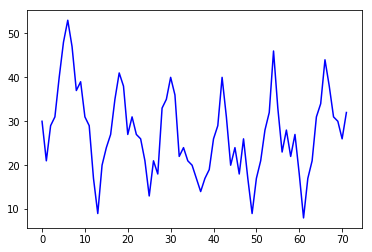

In [24]:
plt.plot(np.concatenate([inp[0,:],out[0,:]]),"b")


AttributeError: 'Tensor' object has no attribute 'ndim'

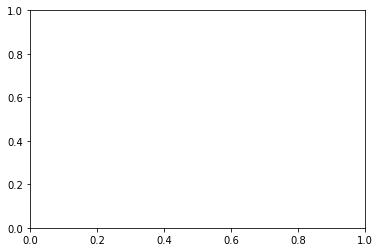

In [27]:
plt.plot(pred[0,:],"r")


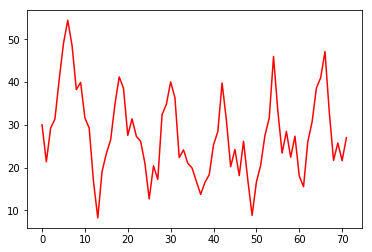

In [379]:
plt.plot(pred[0,:],"r")


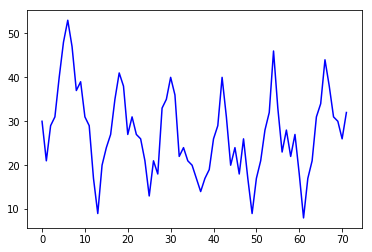

In [380]:
plt.plot(np.concatenate([inp[0,:],out[0,:]]),"b")

In [381]:
plt.plot(np.squeeze(inp.numpy()), 'g') # plotting t, c separately 
plt.plot(np.squeeze(pred), 'b') # plotting t, c separately 
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

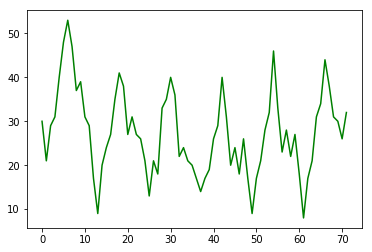

In [299]:
plt.plot(np.concatenate([np.squeeze(inp),np.squeeze(out)]), 'g') # plotting t, c separately 
plt.show()

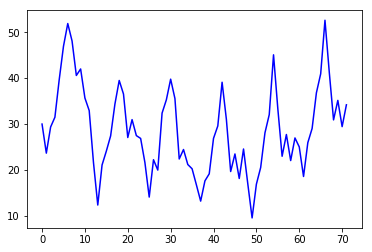

In [300]:
plt.plot(np.squeeze(pred), 'b') # plotting t, c separately 


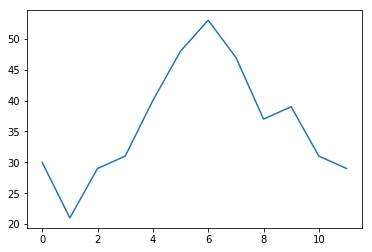

In [235]:
plt.plot(series[0:12])

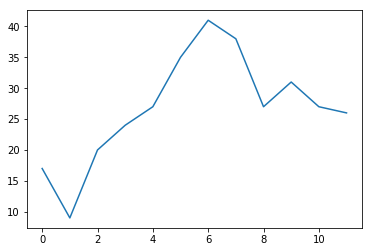

In [236]:
plt.plot(series[12:24])

In [237]:
len(series[12:24])

12

In [238]:
out.shape

(1, 12)

In [239]:
pred.shape

(1, 56)

In [240]:
params=[]
for param in hw.parameters():
    params.append(param)

In [241]:
params

[Parameter containing:
 tensor(-1.2649, requires_grad=True), Parameter containing:
 tensor(-2.8778, requires_grad=True), Parameter containing:
 tensor(1.0469, requires_grad=True), Parameter containing:
 tensor([-0.5125, -0.2710,  3.0907,  0.9330, -1.3761,  1.9721, -0.7254, -1.5417,
         -0.0654,  0.0542, -0.3144,  0.7884], dtype=torch.float64,
        requires_grad=True), Parameter containing:
 tensor(1.9118, requires_grad=True)]

In [242]:
len(params[3].detach().numpy())

12

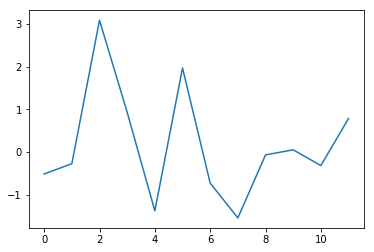

In [243]:
plt.plot(params[3].detach().numpy())

In [261]:
inp=batch[0].float()#.unsqueeze(2)
out=batch[1].float()#.unsqueeze(2).float()
shifts=batch[2].numpy()
#it returns the whole sequence atm 
pred=hw(inp,48,shifts,True)#[:,-12:]
#loss=torch.mean(torch.abs(pred-out))

In [262]:
preds=pred[0][:,-48:]
level=pred[1]
trend=pred[2]
season=pred[3]

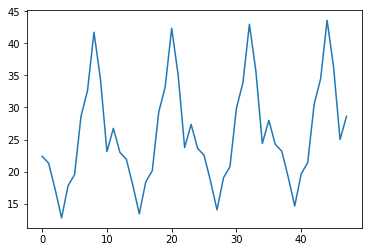

In [263]:
plt.plot(preds.detach().squeeze().numpy())

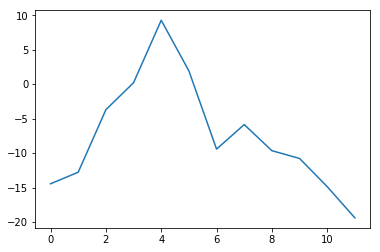

In [251]:
plt.plot(torch.stack(season).detach().squeeze().numpy())

In [253]:
level

tensor([29.7583], grad_fn=<AddBackward0>)

In [252]:
trend

tensor([0.0519], grad_fn=<AddBackward0>)

In [ ]:
plt.plot(params[3].detach().numpy())

In [ ]:
plt.plot(params[3].detach().numpy())

In [ ]:
plt.plot(params[3].detach().numpy())

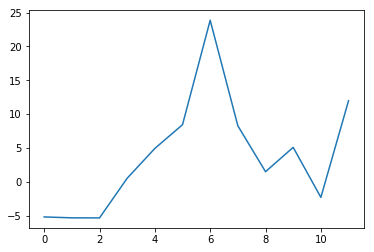

In [329]:
#THe init season it learns with no shifi 
plt.plot(params[3].detach().numpy())